In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
import math
import matplotlib.pyplot as plt
import seaborn as sns

Train dataset shape: (125973, 42)
Test dataset shape: (22544, 42)


<ipython-input-2-b7f7ada191a5>:53: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['class'] = train_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")
<ipython-input-2-b7f7ada191a5>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['class'] = test_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")


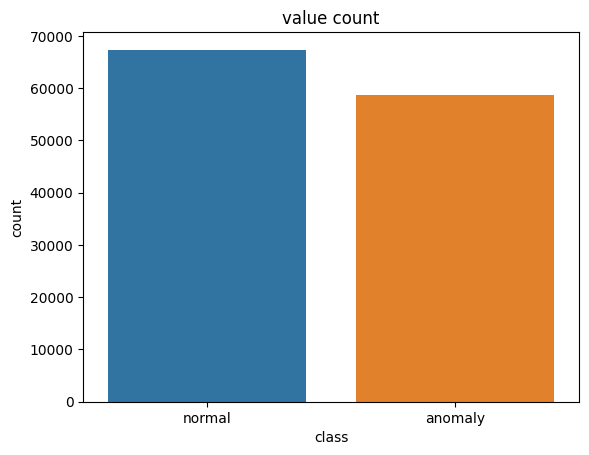

In [ ]:
CSV_HEADER = [
      "duration",
      "protocol_type",
      "service",
      "flag",
      "src_bytes",
      "dst_bytes",
      "land",
      "wrong_fragment",
      "urgent",
      "hot",
      "num_failed_logins",
      "logged_in",
      "num_compromised",
      "root_shell",
      "su_attempted",
      "num_root",
      "num_file_creations",
      "num_shells",
      "num_access_files",
      "num_outbound_cmds",
      "is_host_login",
      "is_guest_login",
      "count",
      "srv_count",
      "serror_rate",
      "srv_serror_rate",
      "rerror_rate",
      "srv_rerror_rate",
      "same_srv_rate",
      "diff_srv_rate",
      "srv_diff_host_rate",
      "dst_host_count",
      "dst_host_srv_count",
      "dst_host_same_srv_rate",
      "dst_host_diff_srv_rate",
      "dst_host_same_src_port_rate",
      "dst_host_srv_diff_host_rate",
      "dst_host_serror_rate",
      "dst_host_srv_serror_rate",
      "dst_host_rerror_rate",
      "dst_host_srv_rerror_rate",
      "class"
]


train_data = pd.read_csv("train.csv", header=None, names=CSV_HEADER)

test_data = pd.read_csv("test.csv", header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")
train_data['class'] = train_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")
test_data['class'] = test_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")

train_data['land'] = train_data['land'].astype(str)
test_data['land'] = test_data['land'].astype(str)

train_data['logged_in'] = train_data['logged_in'].astype(str)
test_data['logged_in'] = test_data['logged_in'].astype(str)

train_data['is_host_login'] = train_data['is_host_login'].astype(str)
test_data['is_host_login'] = test_data['is_host_login'].astype(str)

train_data['is_guest_login'] = train_data['is_guest_login'].astype(str)
test_data['is_guest_login'] = test_data['is_guest_login'].astype(str)

sns.countplot(
    x='class',
    data=train_data)
plt.title('value count')
plt.show()

train_data.protocol_type=train_data.protocol_type.astype('category').cat.codes
train_data.service=train_data.service.astype('category').cat.codes
train_data.flag=train_data.flag.astype('category').cat.codes
train_data.land=train_data.land.astype('category').cat.codes
train_data.logged_in=train_data.logged_in.astype('category').cat.codes
train_data.is_host_login=train_data.is_host_login.astype('category').cat.codes
train_data.is_guest_login=train_data.is_guest_login.astype('category').cat.codes

test_data.protocol_type=test_data.protocol_type.astype('category').cat.codes
test_data.service=test_data.service.astype('category').cat.codes
test_data.flag=test_data.flag.astype('category').cat.codes
test_data.land=test_data.land.astype('category').cat.codes
test_data.logged_in=test_data.logged_in.astype('category').cat.codes
test_data.is_host_login=test_data.is_host_login.astype('category').cat.codes
test_data.is_guest_login=test_data.is_guest_login.astype('category').cat.codes

## Removing outliers and duplicates

In [ ]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)
    return trueList

nonOutlierList = Remove_Outlier_Indices(train_data)
new_train_data = train_data[nonOutlierList]

nonOutlierList = Remove_Outlier_Indices(test_data)
new_test_data = test_data[nonOutlierList]

<ipython-input-3-c287b5c5fb36>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.02)
<ipython-input-3-c287b5c5fb36>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.98)
<ipython-input-3-c287b5c5fb36>:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)


## Merging train and test datasets

In [ ]:
frames = [new_train_data, new_test_data]
df = pd.concat(frames)
df = df.reset_index(drop=True)
df

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0              0              1       20     9        491          0     0   
1              0              2       44     9        146          0     0   
2              0              1       49     5          0          0     0   
3              0              1       24     9        232       8153     0   
4              0              1       24     9        199        420     0   
...          ...            ...      ...   ...        ...        ...   ...   
139899         0              0       14     9       1032          0     0   
139900         0              1       49     9        794        333     0   
139901         0              1       22     9        317        938     0   
139902         0              2       11     9         42         42     0   
139903         0              1       52     1          0          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                  25   
1                    0       0    0  ...                   1   
2                    0       0    0  ...                  26   
3                    0       0    0  ...                 255   
4                    0       0    0  ...                 255   
...                ...     ...  ...  ...                 ...   
139899               0       0    0  ...                 255   
139900               0       0    0  ...                 141   
139901               0       0    0  ...                 255   
139902               0       0    0  ...                 252   
139903               0       0    0  ...                  21   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                         0.17                    0.03   
1                         0.00                    0.60   
2                         0.10                    0.05   
3                         1.00                    0.00   
4                         1.00                    0.00   
...                        ...                     ...   
139899                    1.00                    0.00   
139900                    0.72                    0.06   
139901                    1.00                    0.00   
139902                    0.99                    0.01   
139903                    0.08                    0.03   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.17                         0.00   
1                              0.88                         0.00   
2                              0.00                         0.00   
3                              0.03                         0.04   
4                              0.00                         0.00   
...                             ...                          ...   
139899                         1.00                         0.00   
139900                         0.01                         0.01   
139901                         0.01                         0.01   
139902                         0.00                         0.00   
139903                         0.00                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.05   
1                       0.00                      0.00                  0.00   
2                       1.00                      1.00                  0.00   
3                       0.03                      0.01                  0.00   
4                       0.00                      0.00                  0.00   
...                      ...                       ...                   ...   
139899                  0.00                      0.00                  0.00   
139900                  0.01                      0.00                  0.00   
139901                  0.01                      0.00              

## Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=10)
X = df.drop(['class'], axis=1)
Y = df["class"].astype('category').cat.codes
X_new = selector.fit(X, Y)
X.columns.values[selector.get_support()]

array(['flag', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate'], dtype=object)

In [ ]:
columns = X.columns.values[selector.get_support()]

In [ ]:
columns = []
for c in X.columns.values[selector.get_support()]:
  columns.append(str(c))

In [ ]:
principalDf = pd.DataFrame(data = X
             , columns = X.columns.values[selector.get_support()])
finalDf = pd.concat([principalDf, df["class"]], axis = 1)
finalDf

flag  logged_in  count  serror_rate  srv_serror_rate  same_srv_rate  \
0          9          0      2          0.0              0.0           1.00   
1          9          0     13          0.0              0.0           0.08   
2          5          0    123          1.0              1.0           0.05   
3          9          1      5          0.2              0.2           1.00   
4          9          1     30          0.0              0.0           1.00   
...      ...        ...    ...          ...              ...            ...   
139899     9          0     53          0.0              0.0           1.00   
139900     9          1      1          0.0              0.0           1.00   
139901     9          1      2          0.0              0.0           1.00   
139902     9          0      4          0.0              0.0           1.00   
139903     1          0      4          0.0              0.0           0.25   

        dst_host_srv_count  dst_host_same_srv_rate  dst_host_serror_rate  \
0                       25                    0.17                  0.00   
1                        1                    0.00                  0.00   
2                       26                    0.10                  1.00   
3                      255                    1.00                  0.03   
4                      255                    1.00                  0.00   
...                    ...                     ...                   ...   
139899                 255                    1.00                  0.00   
139900                 141                    0.72                  0.01   
139901                 255                    1.00                  0.01   
139902                 252                    0.99                  0.00   
139903                  21                    0.08                  0.00   

        dst_host_srv_serror_rate    class  
0                           0.00   normal  
1                           0.00   normal  
2                           1.00  anomaly  
3                           0.01   normal  
4                           0.00   normal  
...                          ...      ...  
139899                      0.00  anomaly  
139900                      0.00   normal  
139901                      0.00   normal  
139902                      0.00   normal  
139903                      0.00  anomaly  

[139904 rows x 11 columns]

# Model

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(finalDf, test_size=0.25)
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
CSV_HEADER = []
for x in columns:
  CSV_HEADER.append(x)
CSV_HEADER.append("class")

# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = columns
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}
# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "class"
# A list of the labels of the target features.
TARGET_LABELS = ["normal", "anomaly"]

from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            #print(vocabulary)
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs
learning_rate = 0.01
batch_size = 128
num_epochs = 10


def run_experiment(model):

    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()],
    )
    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    print("Evaluating the model on the test data...")
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return model

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()

finalModel = run_experiment(forest_model)

Start training the model...
Epoch 1/10
820/820 [==============================] - 47s 27ms/step - loss: 0.2367 - sparse_categorical_accuracy: 0.9130
Epoch 2/10
820/820 [==============================] - 16s 20ms/step - loss: 0.1888 - sparse_categorical_accuracy: 0.9268
Epoch 3/10
820/820 [==============================] - 18s 21ms/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9291
Epoch 4/10
820/820 [==============================] - 17s 21ms/step - loss: 0.1821 - sparse_categorical_accuracy: 0.9304
Epoch 5/10
820/820 [==============================] - 17s 20ms/step - loss: 0.1800 - sparse_categorical_accuracy: 0.9312
Epoch 6/10
820/820 [==============================] - 16s 20ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.9317
Epoch 7/10
820/820 [==============================] - 17s 20ms/step - loss: 0.1771 - sparse_categorical_accuracy: 0.9320
Epoch 8/10
820/820 [==============================] - 20s 24ms/step - loss: 0.1763 - sparse_categorical_accuracy: 0.9323
Epoc

274/274 [==============================] - 4s 9ms/step
[[0.91360217 0.03922436]
 [0.08639783 0.96077564]]
ACC: 0.9371889086346885
PR: 0.95883368635097
TPR: 0.9136021730045968
FPR: 0.03922435573521981
F1Score: 0.9356716119522974


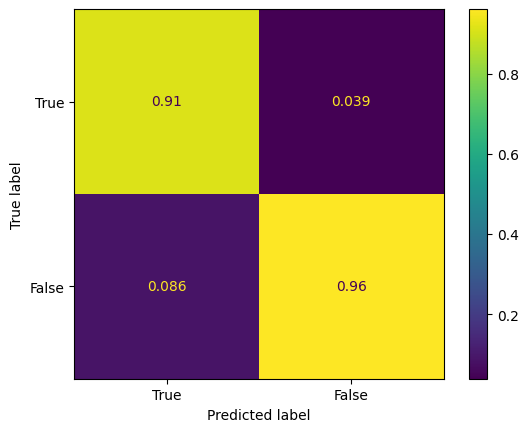

In [ ]:
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
colnames=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'target']
data = pd.read_csv("test_data.csv", names=colnames, header=None)
data['target'].replace('normal', 0,inplace=True)
data['target'].replace('anomaly', 1,inplace=True)
y_test = data['target'].values  # as a numpy array
from sklearn.metrics import confusion_matrix
y_prediction = finalModel.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
TP = result[0][0]
FP = result[0][1]
TN = result[1][1]
FN = result[1][0]
ACC = (TP+TN)/(TP+TN+FP+FN)
PR = TP/(TP+FP) #precision
TPR = TP/(TP+FN) #Recall or True positive rate
FPR = FP/(FP+TN)
F1Score = 2*(PR*TPR)/(PR+TPR)
print("ACC: " + str(ACC))
print("PR: " + str(PR))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("F1Score: " + str(F1Score))
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [True, False])

cm_display.plot()
plt.show()

## CISIDS2017

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
import os

path = r'C:\DRO\DCL_rawdata_files' # use your path
all_files = glob.glob(os.path.join(path , "/content/drive/MyDrive/datasets/CISIDS2017/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2830738                 53           32215                   4   
2830739                 53             324                   2   
2830740              58030              82                   2   
2830741                 53         1048635                   6   
2830742                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2830738                        2                          112   
2830739                        2                           84   
2830740                        1                           31   
2830741                        2                          192   
2830742                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2830738                           152                      28   
2830739                           362                      42   
2830740                             6                      31   
2830741                           256                      32   
2830742                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2830738                      28                     28.0   
2830739                      42                     42.0   
2830740                       0                     15.5   
2830741                      32                     32.0   
2830742                      47                     47.0   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                       0.00000  ...                     20          0.0   
1                       0.00000  ...                     20          0.0   
2                       0.00000  ...                     20          0.0   
3                       0.00000  ...                     20          0.0   
4                       0.00000  ...                     20          0.0   
...                         ...  ...                    ...          ...   
2830738                 0.00000  ...                     20          0.0   
2830739                 0.00000  ...                     20          0.0   
2830740                21.92031  ...                     32          0.0   
2830741                 0.00000  ...                     20          0.0   
2830742                 0.00000  ...                     20          0.0   

          Active Std 

In [ ]:
column_headers = list(frame.columns.values)
column_headers

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 'Fwd PSH Flags',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' P

<ipython-input-5-1c8b013c5f9c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  frame[' Label'] = frame[' Label'].str.replace(r"^(.(?<!BENIGN))*?$", "ANOMALY")


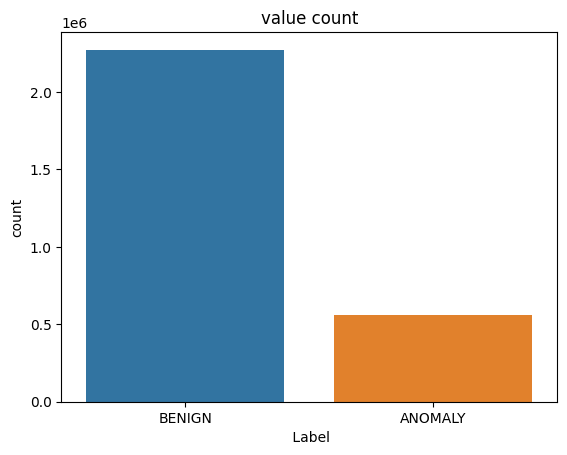

In [ ]:
frame[' Label'] = frame[' Label'].str.replace(r"^(.(?<!BENIGN))*?$", "ANOMALY")
sns.countplot(
    x=' Label',
    data=frame)
plt.title('value count')
plt.show()

In [ ]:
CSV_HEADER = column_headers

In [ ]:
df = frame

In [ ]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)
    return trueList

nonOutlierList = Remove_Outlier_Indices(df)
new_data = df[nonOutlierList]



<ipython-input-8-131013cf66a1>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.02)
<ipython-input-8-131013cf66a1>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.98)
<ipython-input-8-131013cf66a1>:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)


In [ ]:
df = new_data
df = df.reset_index(drop=True)
df

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2539413                 53           32215                   4   
2539414                 53             324                   2   
2539415              58030              82                   2   
2539416                 53         1048635                   6   
2539417                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2539413                        2                          112   
2539414                        2                           84   
2539415                        1                           31   
2539416                        2                          192   
2539417                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2539413                           152                      28   
2539414                           362                      42   
2539415                             6                      31   
2539416                           256                      32   
2539417                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2539413                      28                     28.0   
2539414                      42                     42.0   
2539415                       0                     15.5   
2539416                      32                     32.0   
2539417                      47                     47.0   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                       0.00000  ...                     20          0.0   
1                       0.00000  ...                     20          0.0   
2                       0.00000  ...                     20          0.0   
3                       0.00000  ...                     20          0.0   
4                       0.00000  ...                     20          0.0   
...                         ...  ...                    ...          ...   
2539413                 0.00000  ...                     20          0.0   
2539414                 0.00000  ...                     20          0.0   
2539415                21.92031  ...                     32          0.0   
2539416                 0.00000  ...                     20          0.0   
2539417                 0.00000  ...                     20          0.0   

          Active Std 

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=10)
X = df.drop([' Label'], axis=1)
Y = df[" Label"].astype('category').cat.codes
X_new = selector.fit(X, Y)
X.columns.values[selector.get_support()]

array(['Bwd Packet Length Max', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance', ' Average Packet Size',
       ' Avg Bwd Segment Size', ' Idle Min'], dtype=object)

In [ ]:
columns = X.columns.values[selector.get_support()]

In [ ]:
columns = []
for c in X.columns.values[selector.get_support()]:
  columns.append(str(c))

In [ ]:
principalDf = pd.DataFrame(data = X
             , columns = X.columns.values[selector.get_support()])
finalDf = pd.concat([principalDf, df[" Label"]], axis = 1)
finalDf

Bwd Packet Length Max   Bwd Packet Length Mean  \
0                            0                      0.0   
1                            6                      6.0   
2                            6                      6.0   
3                            6                      6.0   
4                            0                      0.0   
...                        ...                      ...   
2539413                     76                     76.0   
2539414                    181                    181.0   
2539415                      6                      6.0   
2539416                    128                    128.0   
2539417                    113                    113.0   

          Bwd Packet Length Std   Max Packet Length   Packet Length Mean  \
0                           0.0                   6             6.000000   
1                           0.0                   6             6.000000   
2                           0.0                   6             6.000000   
3                           0.0                   6             6.000000   
4                           0.0                   6             6.000000   
...                         ...                 ...                  ...   
2539413                     0.0                  76            41.714286   
2539414                     0.0                 181            97.600000   
2539415                     0.0                  31            17.000000   
2539416                     0.0                 128            53.333333   
2539417                     0.0                 113            65.857143   

          Packet Length Std   Packet Length Variance   Average Packet Size  \
0                  0.000000                 0.000000              9.000000   
1                  0.000000                 0.000000              9.000000   
2                  0.000000                 0.000000              9.000000   
3                  0.000000                 0.000000              9.000000   
4                  0.000000                 0.000000              9.000000   
...                     ...                      ...                   ...   
2539413           23.421602               548.571429             48.666667   
2539414           76.133435              5796.300000            122.000000   
2539415           16.350331               267.333333             22.666667   
2539416           42.332021              1792.000000             60.000000   
2539417           32.204702              1037.142857             76.833333   

          Avg Bwd Segment Size   Idle Min   Label  
0                          0.0          0  BENIGN  
1                          6.0          0  BENIGN  
2                          6.0          0  BENIGN  
3                          6.0          0  BENIGN  
4                          0.0          0  BENIGN  
...                        ...        ...     ...  
2539413                   76.0          0  BENIGN  
2539414                  181.0          0  BENIGN  
2539415                    6.0          0  BENIGN  
2539416                  128.0          0  BENIGN  
2539417                  113.0          0  BENIGN  

[2539418 rows x 11 columns]

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(finalDf, test_size=0.25)
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
CSV_HEADER = []
for x in columns:
  CSV_HEADER.append(x)
CSV_HEADER.append(" Label")

# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = columns
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}
# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = " Label"
# A list of the labels of the target features.
TARGET_LABELS = ["BENIGN", "ANOMALY"]

from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            #print(vocabulary)
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs
learning_rate = 0.01
batch_size = 128
num_epochs = 10


def run_experiment(model):

    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()],
    )
    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    print("Evaluating the model on the test data...")
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return model

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()

finalModel = run_experiment(forest_model)

Start training the model...
Epoch 1/10
14880/14880 [==============================] - 408s 26ms/step - loss: 0.2511 - sparse_categorical_accuracy: 0.8851
Epoch 2/10
14880/14880 [==============================] - 318s 21ms/step - loss: 0.2333 - sparse_categorical_accuracy: 0.8858
Epoch 3/10
14880/14880 [==============================] - 319s 21ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.8862
Epoch 4/10
14880/14880 [==============================] - 321s 22ms/step - loss: 0.2271 - sparse_categorical_accuracy: 0.8895
Epoch 5/10
14880/14880 [==============================] - 320s 21ms/step - loss: 0.2263 - sparse_categorical_accuracy: 0.8895
Epoch 6/10
14880/14880 [==============================] - 315s 21ms/step - loss: 0.2255 - sparse_categorical_accuracy: 0.8892
Epoch 7/10
14880/14880 [==============================] - 325s 22ms/step - loss: 0.2238 - sparse_categorical_accuracy: 0.8902
Epoch 8/10
14880/14880 [==============================] - 321s 22ms/step - loss: 0.2226 - 

4960/4960 [==============================] - 49s 9ms/step
[[0.88787502 0.02786123]
 [0.11212498 0.97213877]]
ACC: 0.9300068949681092
PR: 0.969575052799438
TPR: 0.8878750167992865
FPR: 0.027861226863068127
F1Score: 0.9269282446751819


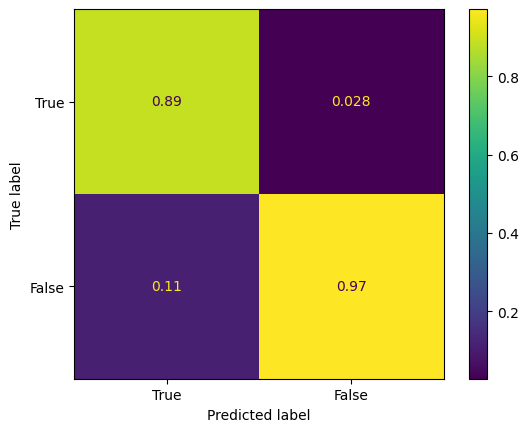

In [ ]:
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
colnames=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'target']
data = pd.read_csv("test_data.csv", names=colnames, header=None)
data['target'].replace('BENIGN', 0,inplace=True)
data['target'].replace('ANOMALY', 1,inplace=True)
y_test = data['target'].values  # as a numpy array
from sklearn.metrics import confusion_matrix
y_prediction = finalModel.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
TP = result[0][0]
FP = result[0][1]
TN = result[1][1]
FN = result[1][0]
ACC = (TP+TN)/(TP+TN+FP+FN)
PR = TP/(TP+FP) #precision
TPR = TP/(TP+FN) #Recall or True positive rate
FPR = FP/(FP+TN)
F1Score = 2*(PR*TPR)/(PR+TPR)
print("ACC: " + str(ACC))
print("PR: " + str(PR))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("F1Score: " + str(F1Score))
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [True, False])

cm_display.plot()
plt.show()

# UNSWB-NB15

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CSV_HEADER = [
"srcip",
"sport",
"dstip",
"dsport",
"proto",
"state",
"dur",
"sbytes",
"dbytes",
"sttl",
"dttl",
"sloss",
"dloss",
"service",
"Sload",
"Dload",
"Spkts",
"Dpkts",
"swin",
"dwin",
"stcpb",
"dtcpb",
"smeansz",
"dmeansz",
"trans_depth",
"res_bdy_len",
"Sjit",
"Djit",
"Stime",
"Ltime",
"Sintpkt",
"Dintpkt",
"tcprtt",
"synack",
"ackdat",
"is_sm_ips_ports",
"ct_state_ttl",
"ct_flw_http_mthd",
"is_ftp_login",
"ct_ftp_cmd",
"ct_srv_src",
"ct_srv_dst",
"ct_dst_ltm",
"ct_src_ ltm",
"ct_src_dport_ltm",
"ct_dst_sport_ltm",
"ct_dst_src_ltm",
"attack_cat",
"Label"
]

In [ ]:
import pandas as pd
import glob
import os

path = r'C:\DRO\DCL_rawdata_files' # use your path
all_files = glob.glob(os.path.join(path , "/content/drive/MyDrive/datasets/UNSW-NB15/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, names=CSV_HEADER,low_memory=False)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
pd.set_option('display.max_columns', None)
frame

srcip  sport          dstip dsport proto state       dur  \
0        59.166.0.9   7045  149.171.126.7     25   tcp   FIN  0.201886   
1        59.166.0.9   9685  149.171.126.2     80   tcp   FIN  5.864748   
2        59.166.0.2   1421  149.171.126.4     53   udp   CON  0.001391   
3        59.166.0.2  21553  149.171.126.2     25   tcp   FIN  0.053948   
4        59.166.0.8  45212  149.171.126.4     53   udp   CON  0.000953   
...             ...    ...            ...    ...   ...   ...       ...   
2540042  59.166.0.8  12520  149.171.126.6  31010   tcp   FIN  0.020383   
2540043  59.166.0.0  18895  149.171.126.9     80   tcp   FIN  1.402957   
2540044  59.166.0.0  30103  149.171.126.5   5190   tcp   FIN  0.007108   
2540045  59.166.0.6  30388  149.171.126.5    111   udp   CON  0.004435   
2540046  59.166.0.0   6055  149.171.126.5  54145   tcp   FIN  0.072974   

         sbytes   dbytes  sttl  dttl  sloss  dloss service         Sload  \
0         37552     3380    31    29     18      8    smtp  1.459438e+06   
1         19410  1087890    31    29      2    370    http  2.640454e+04   
2           146      178    31    29      0      0     dns  4.198418e+05   
3         37812     3380    31    29     19      8    smtp  5.503374e+06   
4           146      178    31    29      0      0     dns  6.128017e+05   
...         ...      ...   ...   ...    ...    ...     ...           ...   
2540042     320     1874    31    29      1      2       -  1.047932e+05   
2540043   19410  1087890    31    29      2    370    http  1.103783e+05   
2540044    2158     2464    31    29      6      6       -  2.328644e+06   
2540045     568      304    31    29      0      0       -  7.684329e+05   
2540046    4238    60788    31    29      7     30       -  4.582454e+05   

                Dload  Spkts  Dpkts  swin  dwin       stcpb       dtcpb  \
0        1.307669e+05     52     42   255   255  1422136554  3572668484   
1        1.481983e+06    364    746   255   255   389619597   394688654   
2        5.118620e+05      2      2     0     0           0           0   
3        4.893601e+05     54     42   255   255  4047523379  1903327524   
4        7.471144e+05      2      2     0     0           0           0   
...               ...    ...    ...   ...   ...         ...         ...   
2540042  6.436736e+05      6      8   255   255  3208686479  3225486168   
2540043  6.195098e+06    364    746   255   255   283296697  2429736754   
2540044  2.658413e+06     24     24   255   255   703293844  2848960529   
2540045  4.112740e+05      4      4     0     0           0           0   
2540046  6.571546e+06     72     72   255   255  1003293149  1003585034   

         smeansz  dmeansz  trans_depth  res_bdy_len         Sjit        Djit  \
0            722       80            0            0   456.043567   15.530109   
1             53     1458            1            0  1031.366423  690.219581   
2             73       89            0            0     0.000000    0.000000   
3            700       80            0            0    65.909688    3.155258   
4             73       89            0            0     0.000000    0.000000   
...          ...      ...          ...          ...          ...         ...   
2540042       53      234            0            0   212.810729    3.079195   
2540043       53     1458            1         3924   203.808900  114.173588   
2540044       90      103            0            0    17.627831    0.432619   
2540045      142       76            0            0     1.638604    1.390643   
2540046       59      844            0            0    62.045310   61.899776   

              Stime       Ltime    Sintpkt   Dintpkt    tcprtt    synack  \
0        1424250009  1424250009   3.943843  4.912488  0.000590  0.000473   
1        1424250003  1424250009  16.155447  7.871279  0.000771  0.000638   
2        1424250009  1424250009   0.009000  0.002000  0.000000  0.000000   
3        1424250009  1424250009   1.011547  1.

In [ ]:
frame.srcip = frame.srcip.astype('category').cat.codes
frame.dstip = frame.dstip.astype('category').cat.codes
frame.proto = frame.proto.astype('category').cat.codes
frame.state = frame.state.astype('category').cat.codes
frame.service = frame.service.astype('category').cat.codes
frame.ct_flw_http_mthd = frame.ct_flw_http_mthd.astype('category').cat.codes
frame.is_ftp_login = frame.is_ftp_login.astype('category').cat.codes
frame.ct_ftp_cmd = frame.ct_ftp_cmd.astype('category').cat.codes
frame['Label'] = frame['Label'].astype(str)
frame['Label'] = frame['Label'].str.replace("1", "anomaly")
frame['Label'] = frame['Label'].str.replace("0", "normal")
frame = frame.drop('attack_cat', axis=1)
frame

srcip  sport  dstip dsport  proto  state       dur  sbytes   dbytes  \
0           42   7045     25     25    114      5  0.201886   37552     3380   
1           42   9685     20     80    114      5  5.864748   19410  1087890   
2           35   1421     22     53    120      2  0.001391     146      178   
3           35  21553     20     25    114      5  0.053948   37812     3380   
4           41  45212     22     53    120      2  0.000953     146      178   
...        ...    ...    ...    ...    ...    ...       ...     ...      ...   
2540042     41  12520     24  31010    114      5  0.020383     320     1874   
2540043     33  18895     27     80    114      5  1.402957   19410  1087890   
2540044     33  30103     23   5190    114      5  0.007108    2158     2464   
2540045     39  30388     23    111    120      2  0.004435     568      304   
2540046     33   6055     23  54145    114      5  0.072974    4238    60788   

         sttl  dttl  sloss  dloss  service         Sload         Dload  Spkts  \
0          31    29     18      8        9  1.459438e+06  1.307669e+05     52   
1          31    29      2    370        5  2.640454e+04  1.481983e+06    364   
2          31    29      0      0        2  4.198418e+05  5.118620e+05      2   
3          31    29     19      8        9  5.503374e+06  4.893601e+05     54   
4          31    29      0      0        2  6.128017e+05  7.471144e+05      2   
...       ...   ...    ...    ...      ...           ...           ...    ...   
2540042    31    29      1      2        0  1.047932e+05  6.436736e+05      6   
2540043    31    29      2    370        5  1.103783e+05  6.195098e+06    364   
2540044    31    29      6      6        0  2.328644e+06  2.658413e+06     24   
2540045    31    29      0      0        0  7.684329e+05  4.112740e+05      4   
2540046    31    29      7     30        0  4.582454e+05  6.571546e+06     72   

         Dpkts  swin  dwin       stcpb       dtcpb  smeansz  dmeansz  \
0           42   255   255  1422136554  3572668484      722       80   
1          746   255   255   389619597   394688654       53     1458   
2            2     0     0           0           0       73       89   
3           42   255   255  4047523379  1903327524      700       80   
4            2     0     0           0           0       73       89   
...        ...   ...   ...         ...         ...      ...      ...   
2540042      8   255   255  3208686479  3225486168       53      234   
2540043    746   255   255   283296697  2429736754       53     1458   
2540044     24   255   255   703293844  2848960529       90      103   
2540045      4     0     0           0           0      142       76   
2540046     72   255   255  1003293149  1003585034       59      844   

         trans_depth  res_bdy_len         Sjit        Djit       Stime  \
0                  0            0   456.043567   15.530109  1424250009   
1                  1            0  1031.366423  690.219581  1424250003   
2                  0            0     0.000000    0.000000  1424250009   
3                  0            0    65.909688    3.155258  1424250009   
4                  0            0     0.000000    0.000000  1424250009   
...              ...          ...          ...         ...         ...   
2540042            0            0   212.810729    3.079195  1421955842   
2540043            1         3924   203.808900  114.173588  1421955841   
2540044            0            0    17.627831    0.432619  1421955842   
2540045            0            0     1.638604    1.390643  1421955842   
2540046            0            0    62.045310   61.899776  1421955842   

              Ltime    Sintpkt   Dintpkt    tcprtt    synack    ackdat  \
0        1424250009   3.943843  4.912488  0.000590  0.000473  0.000117   
1        1424250009  16.155447  7.871279  0.000771  0.000638  0.000133   
2        1424250009   0.009000  0.002000  0.000000  0.000000  0.000000   
3        1424250009   1.0

In [ ]:
column_headers = list(frame.columns.values)
column_headers

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'service',
 'Sload',
 'Dload',
 'Spkts',
 'Dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'Sjit',
 'Djit',
 'Stime',
 'Ltime',
 'Sintpkt',
 'Dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'Label']

In [ ]:
CSV_HEADER = column_headers
df = frame
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)
    return trueList

nonOutlierList = Remove_Outlier_Indices(df)
new_data = df[nonOutlierList]

df = new_data
df = df.reset_index(drop=True)
del new_data
del nonOutlierList
del li
del frame
import gc
gc.collect()

<ipython-input-7-033f6da543bf>:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.02)
<ipython-input-7-033f6da543bf>:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.98)
<ipython-input-7-033f6da543bf>:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)


49

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=10)
X = df.drop(['Label'], axis=1)
Y = df["Label"].astype('category').cat.codes
X_new = selector.fit(X, Y)
X.columns.values[selector.get_support()]

array(['state', 'sttl', 'ct_state_ttl', 'ct_srv_src', 'ct_srv_dst',
       'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm'], dtype=object)

In [ ]:
columns = X.columns.values[selector.get_support()]

In [ ]:
columns = []
for c in X.columns.values[selector.get_support()]:
  columns.append(str(c))

In [ ]:
principalDf = pd.DataFrame(data = X
             , columns = X.columns.values[selector.get_support()])
finalDf = pd.concat([principalDf, df["Label"]], axis = 1)
finalDf

state  sttl  ct_state_ttl  ct_srv_src  ct_srv_dst  ct_dst_ltm  \
0            5    31             0           2           2           7   
1            5    31             0           3           1           4   
2            2    31             0           3           5           2   
3            5    31             0           1           1           4   
4            2    31             0           2           5           2   
...        ...   ...           ...         ...         ...         ...   
2438669      5    31             0           8          20           7   
2438670      5    31             0           1           1           2   
2438671      5    31             0          13          13           6   
2438672      2    31             0          10          13           6   
2438673      5    31             0          13          13           6   

         ct_src_ ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0                  4                 1                 1               3   
1                  4                 1                 1               1   
2                  7                 1                 1               4   
3                  7                 1                 1               3   
4                  1                 1                 1               2   
...              ...               ...               ...             ...   
2438669            5                 1                 1               4   
2438670            7                 2                 2               2   
2438671            7                 2                 1               2   
2438672            5                 1                 1               3   
2438673            7                 1                 1               2   

          Label  
0        normal  
1        normal  
2        normal  
3        normal  
4        normal  
...         ...  
2438669  normal  
2438670  normal  
2438671  normal  
2438672  normal  
2438673  normal  

[2438674 rows x 11 columns]

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(finalDf, test_size=0.25)
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
CSV_HEADER = []
for x in columns:
  CSV_HEADER.append(x)
CSV_HEADER.append("Label")

# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = columns
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}
# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "Label"
# A list of the labels of the target features.
TARGET_LABELS = ["normal", "anomaly"]

from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            #print(vocabulary)
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs
learning_rate = 0.01
batch_size = 128
num_epochs = 10


def run_experiment(model):

    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()],
    )
    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    print("Evaluating the model on the test data...")
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return model

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()

finalModel = run_experiment(forest_model)

Start training the model...
Epoch 1/10
14290/14290 [==============================] - 390s 25ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9887
Epoch 2/10
14290/14290 [==============================] - 307s 21ms/step - loss: 0.0309 - sparse_categorical_accuracy: 0.9902
Epoch 3/10
14290/14290 [==============================] - 301s 21ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9903
Epoch 4/10
14290/14290 [==============================] - 277s 19ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9903
Epoch 5/10
14290/14290 [==============================] - 307s 22ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9904
Epoch 6/10
14290/14290 [==============================] - 297s 21ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9904
Epoch 7/10
14290/14290 [==============================] - 303s 21ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9904
Epoch 8/10
14290/14290 [==============================] - 303s 21ms/step - loss: 0.0294 - 

4764/4764 [==============================] - 47s 9ms/step
[[0.99675629 0.05519602]
 [0.00324371 0.94480398]]
ACC: 0.9707801335476056
PR: 0.9475299209852083
TPR: 0.9967562878472034
FPR: 0.0551960207519923
F1Score: 0.9715199360823916


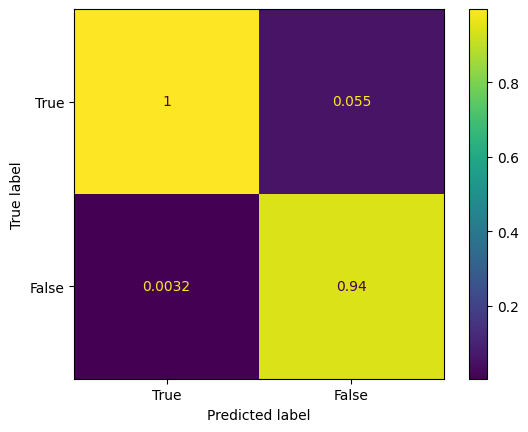

In [ ]:
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
colnames=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'target']
data = pd.read_csv("test_data.csv", names=colnames, header=None)
data['target'].replace('normal', 0,inplace=True)
data['target'].replace('anomaly', 1,inplace=True)
y_test = data['target'].values  # as a numpy array
from sklearn.metrics import confusion_matrix
y_prediction = finalModel.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
TP = result[0][0]
FP = result[0][1]
TN = result[1][1]
FN = result[1][0]
ACC = (TP+TN)/(TP+TN+FP+FN)
PR = TP/(TP+FP) #precision
TPR = TP/(TP+FN) #Recall or True positive rate
FPR = FP/(FP+TN)
F1Score = 2*(PR*TPR)/(PR+TPR)
print("ACC: " + str(ACC))
print("PR: " + str(PR))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("F1Score: " + str(F1Score))
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [True, False])

cm_display.plot()
plt.show()